In [1]:
import random
import math
import seaborn as sns
import matplotlib.pyplot

In [22]:
import random
import math

#
# Shorthand:
#   "pd_" as a variable prefix means "partial derivative"
#   "d_" as a variable prefix means "derivative"
#   "_wrt_" is shorthand for "with respect to"
#   "w_ho" and "w_ih" are the index of weights from hidden to output layer neurons and input to hidden layer neurons respectively
#
# Comment references:
#
# [1] Wikipedia article on Backpropagation
#   http://en.wikipedia.org/wiki/Backpropagation#Finding_the_derivative_of_the_error
# [2] Neural Networks for Machine Learning course on Coursera by Geoffrey Hinton
#   https://class.coursera.org/neuralnets-2012-001/lecture/39
# [3] The Back Propagation Algorithm
#   https://www4.rgu.ac.uk/files/chapter3%20-%20bp.pdf

class NeuralNetwork:
    LEARNING_RATE = 0.5

    def __init__(self, num_inputs, num_hidden, num_outputs, hidden_layer_weights = None, hidden_layer_bias = None, output_layer_weights = None, output_layer_bias = None):
        self.num_inputs = num_inputs

        self.hidden_layer = NeuronLayer(num_hidden, hidden_layer_bias)
        self.output_layer = NeuronLayer(num_outputs, output_layer_bias)

        self.init_weights_from_inputs_to_hidden_layer_neurons(hidden_layer_weights)
        self.init_weights_from_hidden_layer_neurons_to_output_layer_neurons(output_layer_weights)

    def init_weights_from_inputs_to_hidden_layer_neurons(self, hidden_layer_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer.neurons)):
            for i in range(self.num_inputs):
                if not hidden_layer_weights:
                    self.hidden_layer.neurons[h].weights.append(random.random())
                else:
                    self.hidden_layer.neurons[h].weights.append(hidden_layer_weights[weight_num])
                weight_num += 1

    def init_weights_from_hidden_layer_neurons_to_output_layer_neurons(self, output_layer_weights):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer.neurons)):
                if not output_layer_weights:
                    self.output_layer.neurons[o].weights.append(random.random())
                else:
                    self.output_layer.neurons[o].weights.append(output_layer_weights[weight_num])
                weight_num += 1

    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer')
        self.hidden_layer.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')
        print()

    def feed_forward(self, inputs):
        hidden_layer_outputs = self.hidden_layer.feed_forward(inputs)
        return self.output_layer.feed_forward(hidden_layer_outputs)

    # Uses online learning, ie updating the weights after each training case
    def train(self, training_inputs, training_outputs):
        self.feed_forward(training_inputs)

        # 1. Output neuron deltas
        pd_errors_wrt_output_neuron_total_net_input = [0] * len(self.output_layer.neurons)
        for o in range(len(self.output_layer.neurons)):

            # ∂E/∂zⱼ
            pd_errors_wrt_output_neuron_total_net_input[o] = self.output_layer.neurons[o].calculate_pd_error_wrt_total_net_input(training_outputs[o])

        # 2. Hidden neuron deltas
        pd_errors_wrt_hidden_neuron_total_net_input = [0] * len(self.hidden_layer.neurons)
        for h in range(len(self.hidden_layer.neurons)):

            # We need to calculate the derivative of the error with respect to the output of each hidden layer neuron
            # dE/dyⱼ = Σ ∂E/∂zⱼ * ∂z/∂yⱼ = Σ ∂E/∂zⱼ * wᵢⱼ
            d_error_wrt_hidden_neuron_output = 0
            for o in range(len(self.output_layer.neurons)):
                d_error_wrt_hidden_neuron_output += pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].weights[h]

            # ∂E/∂zⱼ = dE/dyⱼ * ∂zⱼ/∂
            pd_errors_wrt_hidden_neuron_total_net_input[h] = d_error_wrt_hidden_neuron_output * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_input()

        # 3. Update output neuron weights
        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):

                # ∂Eⱼ/∂wᵢⱼ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢⱼ
                pd_error_wrt_weight = pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].calculate_pd_total_net_input_wrt_weight(w_ho)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.output_layer.neurons[o].weights[w_ho] -= self.LEARNING_RATE * pd_error_wrt_weight

        # 4. Update hidden neuron weights
        for h in range(len(self.hidden_layer.neurons)):
            for w_ih in range(len(self.hidden_layer.neurons[h].weights)):

                # ∂Eⱼ/∂wᵢ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢ
                pd_error_wrt_weight = pd_errors_wrt_hidden_neuron_total_net_input[h] * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_weight(w_ih)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.hidden_layer.neurons[h].weights[w_ih] -= self.LEARNING_RATE * pd_error_wrt_weight

    def calculate_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                total_error += self.output_layer.neurons[o].calculate_error(training_outputs[o])
        return total_error

class NeuronLayer:
    def __init__(self, num_neurons, bias):

        # Every neuron in a layer shares the same bias
        self.bias = bias if bias else random.random()

        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.bias))

    def inspect(self):
        print('Neurons:', len(self.neurons))
        for n in range(len(self.neurons)):
            print(' Neuron', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs

class Neuron:
    def __init__(self, bias):
        self.bias = bias
        self.weights = []

    def calculate_output(self, inputs):
        self.inputs = inputs
        self.output = self.squash(self.calculate_total_net_input())
        return self.output

    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    # Apply the logistic function to squash the output of the neuron
    # The result is sometimes referred to as 'net' [2] or 'net' [1]
    def squash(self, total_net_input):
        return 1 / (1 + math.exp(-total_net_input))

    # Determine how much the neuron's total input has to change to move closer to the expected output
    #
    # Now that we have the partial derivative of the error with respect to the output (∂E/∂yⱼ) and
    # the derivative of the output with respect to the total net input (dyⱼ/dzⱼ) we can calculate
    # the partial derivative of the error with respect to the total net input.
    # This value is also known as the delta (δ) [1]
    # δ = ∂E/∂zⱼ = ∂E/∂yⱼ * dyⱼ/dzⱼ
    #
    def calculate_pd_error_wrt_total_net_input(self, target_output):
        return self.calculate_pd_error_wrt_output(target_output) * self.calculate_pd_total_net_input_wrt_input();

    # The error for each neuron is calculated by the Mean Square Error method:
    def calculate_error(self, target_output):
        return 0.5 * (target_output - self.output) ** 2

    # The partial derivate of the error with respect to actual output then is calculated by:
    # = 2 * 0.5 * (target output - actual output) ^ (2 - 1) * -1
    # = -(target output - actual output)
    #
    # The Wikipedia article on backpropagation [1] simplifies to the following, but most other learning material does not [2]
    # = actual output - target output
    #
    # Alternative, you can use (target - output), but then need to add it during backpropagation [3]
    #
    # Note that the actual output of the output neuron is often written as yⱼ and target output as tⱼ so:
    # = ∂E/∂yⱼ = -(tⱼ - yⱼ)
    def calculate_pd_error_wrt_output(self, target_output):
        return -(target_output - self.output)

    # The total net input into the neuron is squashed using logistic function to calculate the neuron's output:
    # yⱼ = φ = 1 / (1 + e^(-zⱼ))
    # Note that where ⱼ represents the output of the neurons in whatever layer we're looking at and ᵢ represents the layer below it
    #
    # The derivative (not partial derivative since there is only one variable) of the output then is:
    # dyⱼ/dzⱼ = yⱼ * (1 - yⱼ)
    def calculate_pd_total_net_input_wrt_input(self):
        return self.output * (1 - self.output)

    # The total net input is the weighted sum of all the inputs to the neuron and their respective weights:
    # = zⱼ = netⱼ = x₁w₁ + x₂w₂ ...
    #
    # The partial derivative of the total net input with respective to a given weight (with everything else held constant) then is:
    # = ∂zⱼ/∂wᵢ = some constant + 1 * xᵢw₁^(1-0) + some constant ... = xᵢ
    def calculate_pd_total_net_input_wrt_weight(self, index):
        return self.inputs[index]

###

# Blog post example:

# nn = NeuralNetwork(2, 2, 2, hidden_layer_weights=[0.15, 0.2, 0.25, 0.3], hidden_layer_bias=0.35, output_layer_weights=[0.4, 0.45, 0.5, 0.55], output_layer_bias=0.6)
# for i in range(10000):
#     nn.train([0.05, 0.1], [0.01, 0.99])
#     print(i, round(nn.calculate_total_error([[[0.05, 0.1], [0.01, 0.99]]]), 9))

# OR example:

training_sets = [
    [[0, 0], [0]],
    [[0, 1], [1]],
    [[1, 0], [1]],
    [[1, 1], [1]]
]

nn = NeuralNetwork(len(training_sets[0][0]), 5, len(training_sets[0][1]))
global iteration_number

global error_added
iteration_number = list()
error_added = list()
for i in range(10000):
    training_inputs, training_outputs = random.choice(training_sets)
    nn.train(training_inputs, training_outputs)
    error_added.append(nn.calculate_total_error(training_sets))
    if i== 10:
        print(f"Training sample {i}")
        print(f"{i}, Error : {nn.calculate_total_error(training_sets)}")
        print(nn.inspect())
    if i== 9990:
        print(f"Training sample {i}")
        print(f"{i}, Error : {nn.calculate_total_error(training_sets)}")
        print(nn.inspect()) 



Training sample 10
10, Error : 0.3896905328825308
------
* Inputs: 2
------
Hidden Layer
Neurons: 5
 Neuron 0
  Weight: 0.4891525765041752
  Weight: 0.2734092020906974
  Bias: 0.41653984419151113
 Neuron 1
  Weight: 0.2973239726650529
  Weight: 0.23395385592296175
  Bias: 0.41653984419151113
 Neuron 2
  Weight: 0.2133950045077842
  Weight: 0.6535484615301254
  Bias: 0.41653984419151113
 Neuron 3
  Weight: 0.7073007207627064
  Weight: 0.473072022217133
  Bias: 0.41653984419151113
 Neuron 4
  Weight: 0.1162932866171462
  Weight: 0.253491071102056
  Bias: 0.41653984419151113
------
* Output Layer
Neurons: 1
 Neuron 0
  Weight: 0.2837811770103914
  Weight: 0.7946370014269102
  Weight: 0.17303745638906762
  Weight: 0.14226123876644636
  Weight: 0.1829947044534695
  Bias: 0.820742329903317
------

None
Training sample 9990
9990, Error : 0.001729230823105676
------
* Inputs: 2
------
Hidden Layer
Neurons: 5
 Neuron 0
  Weight: 0.24122407528757786
  Weight: -0.010453832448332647
  Bias: 0.4165

Text(0, 0.5, 'Error')

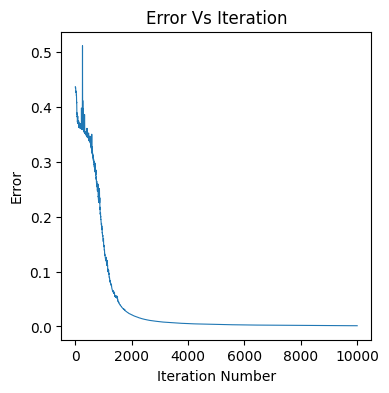

In [3]:
a = matplotlib.pyplot.figure()
a.set_figwidth(4)
a.set_figheight(4)
error_added        

matplotlib.pyplot.plot(error_added,label='Error',linestyle='-',linewidth=0.8)
matplotlib.pyplot.title("Error Vs Iteration")
matplotlib.pyplot.xlabel("Iteration Number")
matplotlib.pyplot.ylabel("Error")


In [4]:
help(matplotlib.pyplot.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f